### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from animator import SacSacAnimator
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook

### Release Rates

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"

In [4]:
# quanta_h5 = "/mnt/Data/prerna_velocity/2021_06_30/waveforms/quantum_pack.h5"
# quanta_h5 = "/mnt/Data/prerna_velocity/2021_05_12_v2/waveforms/quantum_pack.h5"
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
# if False:
#     peak_ratio = (
#         np.max(release_rates["DD"][500]["static_spot"]) 
#         / np.max(release_rates["PD"][500]["static_spot"])
#     )
#     release_rates["PD"][500]["static_spot"] = (
#         release_rates["PD"][500]["static_spot"] * peak_ratio)

# NOTE: faked rates for testing. Sust into square, trans cut off early
# release_rates["PD"][500]["static_spot"][1:] = release_rates["PD"][500]["static_spot"][6]
# release_rates["DD"][500]["static_spot"][50:] = 0

<IPython.core.display.Javascript object>


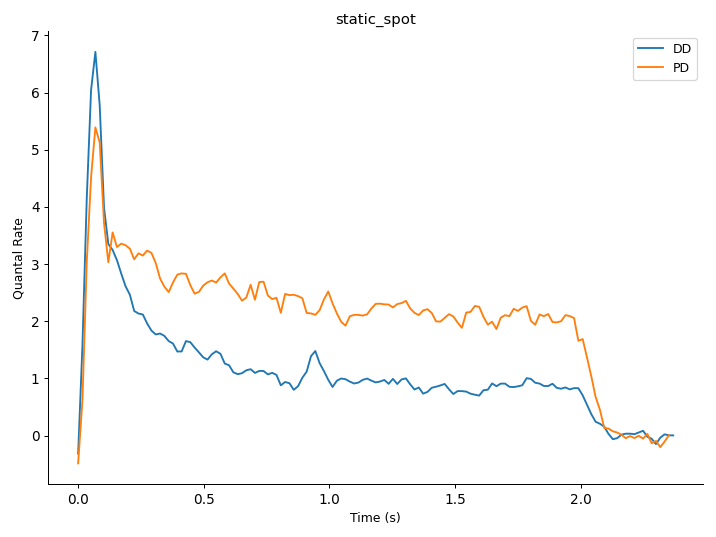

In [5]:
vel = 500
rate_dt = 1 / 58.25

rate_fig, rate_ax = plt.subplots(
    len(release_rates["DD"][vel]), sharex=True, sharey=True, figsize=(8, 6))
rate_ax = [rate_ax] if len(release_rates["DD"][vel]) == 1 else rate_ax
for depth, stims in release_rates.items():
    for ax, (stim, rate) in zip(rate_ax, stims[vel].items()):
        ax.plot(np.arange(len(rate)) * rate_dt, rate, label=depth)

for ax, stim in zip(rate_ax, release_rates["DD"][vel].keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

rate_ax[-1].set_xlabel("Time (s)")
rate_fig.tight_layout()
rate_fig.show()

In [6]:
trans = release_rates["DD"][500]["static_spot"]
peak_ratio = np.max(trans) / np.max(release_rates["PD"][500]["static_spot"])
sust = release_rates["PD"][500]["static_spot"] * peak_ratio

rates = {
    "trans": trans,
    "sust": sust,
}

interp_dt = 1 / 1000  # for model
dt_conv = rate_dt / interp_dt
interp_rates = {
    bp: np.interp(
        np.arange(np.ceil(len(rate) * dt_conv)) * interp_dt,
        np.arange(len(rate)) * rate_dt,
        rate
    ) 
    for bp, rate in rates.items()
}

release_scale = 1 / dt_conv
# release_scale = 1.
bp_releasers = {
    "sust": train_maker(interp_rates["sust"] * release_scale, interp_dt) ,
    "trans": train_maker(interp_rates["trans"] * release_scale, interp_dt)
}

<IPython.core.display.Javascript object>


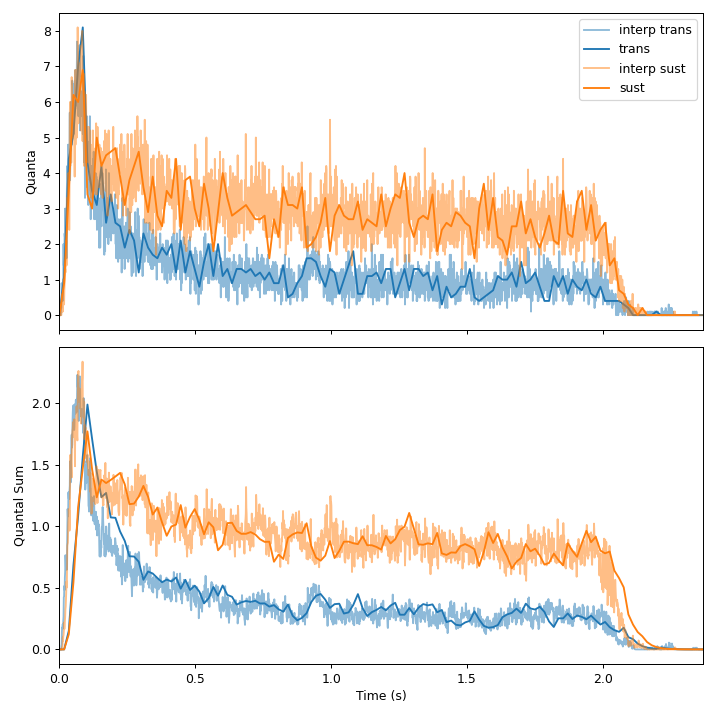

In [7]:
reps = 10
rng = np.random.default_rng()

rate_poisson_fig, rate_poisson_ax = plt.subplots(2, sharex=True, figsize=(8, 8))

for bp, c in zip(rates.keys(), ["C0", "C1"]):
    rate_x = np.arange(len(rates[bp])) * rate_dt
    interp_x = np.arange(len(interp_rates[bp])) * interp_dt
    
    total_quanta = np.sum([poisson_of_release(rng, rates[bp]) for _ in range(reps)], axis=0)
    quantal_sum = sum_quanta(
        total_quanta,
        np.arange(len(total_quanta)) * rate_dt, quantum_pack["quantum"], 
        rate_dt
    ) / reps
    quanta = total_quanta / reps
    
    interp_total_quanta = np.sum(
        [poisson_of_release(rng, interp_rates[bp]) for _ in range(reps)], axis=0)
    interp_quantal_sum = sum_quanta(
        interp_total_quanta,
        np.arange(len(interp_total_quanta)) * interp_dt, quantum_pack["quantum"], 
        interp_dt
    ) / reps
    interp_quanta = interp_total_quanta / reps
    
    interp_rpq_sum_xaxis = np.arange(len(interp_quantal_sum)) * interp_dt
    rate_poisson_ax[0].plot(
        np.arange(len(interp_total_quanta)) * interp_dt, interp_quanta,
        label="interp " + bp, 
        alpha=0.5,
        c=c,
    )
    rate_poisson_ax[1].plot(interp_rpq_sum_xaxis, interp_quantal_sum, alpha=0.5, c=c)
    
    rpq_sum_xaxis = np.arange(len(quantal_sum)) * rate_dt
    rate_poisson_ax[0].plot(
        np.arange(len(total_quanta)) * rate_dt, quanta, label=bp, c=c)
    rate_poisson_ax[1].plot(rpq_sum_xaxis, quantal_sum, c=c)
    

rate_poisson_ax[0].set_ylabel("Quanta")
rate_poisson_ax[1].set_ylabel("Quantal Sum")
rate_poisson_ax[1].set_xlabel("Time (s)")
rate_poisson_ax[1].set_xlim(0, len(total_quanta) * rate_dt)
rate_poisson_ax[0].legend()
rate_poisson_fig.tight_layout()
rate_poisson_fig.show()

In [8]:
# vlasits 2016 used 313pS per vesicle, with 0.14 rise and 0.54 decay
# neuron weight is in uS, so that would be 0.000313
toy_bps = {
    "bp_props": {
        "sust": {"tau1": 0.14, "tau2": 0.54, "rev": 0, "weight": .000313, "delay": 0},
        "trans": { "tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .000313, "delay": 0},    
    },
    "bp_locs": {
        "sust": [10, 20, 25, 30, 40, 50], 
        "trans": [20, 40, 50, 60, 70, 75, 80, 85, 90, 100, 110, 120]
    },
}

toy_gaba_props = {
    "locs": [15],  # distance from soma [um]
    "thresh": -50,  # pre-synaptic release threshold
    "tau1": .1,  # inhibitory conductance rise tau [ms]
#     "tau2": 60,  # inhibitory conductance decay tau [ms]
    "tau2": 100,  # inhibitory conductance decay tau [ms]
    "rev": -60,  # inhibitory reversal potential [mV]
#     "weight": .001,  # weight of inhibitory NetCons [uS]
    "weight": .00,  # weight of inhibitory NetCons [uS]
#     "delay": .5,
    "delay": 0.,
}

vlasists = {
    "soma_gleak_hh": 1 / 21700,
    "dend_gleak_hh": 1 / 21700,
    "soma_ra": 150,
    "dend_ra": 150,
}


high_ca = {
    "term_cat": 0., #0.003,  # 0.0003,
    "term_cal": 0.000,
    "term_can": 0.0003, # 0.0003
    "term_cap": 0.0001, # 0.0003
    "term_na": 0.0001,
    "term_k": 0.0,
    "soma_k": .05,
    "initial_k": 0.01,
    "term_nav1_8": 25e-5, #60e-3,
    "term_kv3_3": 0.05, #0.05,
}


basic_toy_params = {
    **toy_bps,
    **vlasists,
    **high_ca,
    "gaba_props": toy_gaba_props,
    "sink_dend_locs": [],
    "sink_orders": [],
    "bp_releasers": bp_releasers,
}

### Load existing data, or run NEURON model to generate new data
Parameters can be provided to the `SacPair` class in the form of a dict which will be used to overwrite the default properties of the `Sac` objects generated (see `sac_pair.py`).

### Various example `.h5`s:

In [9]:
model_path = base_path + "model_runs/flash_static_rates/"
save_name = "sust_trans_bp_vc"
load_name = None

if load_name is not None:
    with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
        data = unpack_hdf(f)
else:
    import sac_pair
    model = sac_pair.SacPair(sac_params=basic_toy_params)
    runner = sac_pair.Runner(model, data_path=model_path)
    runner.place_vc()
#     runner.unify_bps({"tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .000313, "delay": 0})
    data = runner.flash_run(1000)
#     data = runner.isolated_input_battery(
# #         [1000.0],
#         bp_releasers["sust"](rng, 1000),
# #         bp_releasers["trans"](rng, 1000),
#         n_trials=3,
#     )
    pack_hdf(model_path + save_name, data)

model_params = json.loads(data["model_params"])
exp_params = json.loads(data["exp_params"])
data = data["data"]

trial 0... trial 1... trial 2... trial 3... trial 4... trial 5... trial 6... trial 7... trial 8... trial 9... 

In [10]:
data["soma"]["a"]["v"].shape

(10, 1, 4001)

In [11]:
dt = exp_params["dt"]
rec_xaxis = np.arange(0, exp_params["tstop"] + dt, dt)
soma_v = np.squeeze(data["soma"]["a"]["v"])
avg_soma_v = np.mean(soma_v, axis=0)
term_v = np.squeeze(data["term"]["a"]["v"])
avg_term_v = np.mean(term_v, axis=0)

<IPython.core.display.Javascript object>


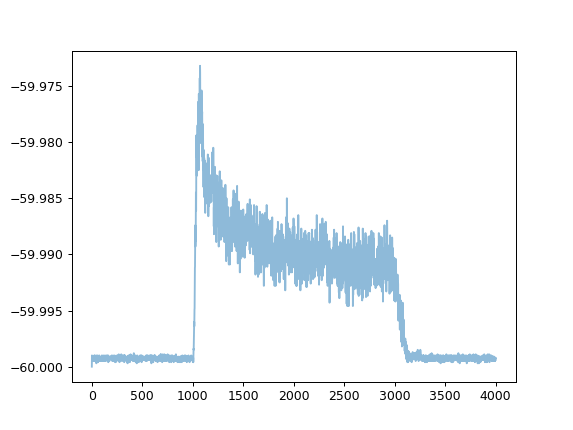

In [12]:
soma_v_avg_fig, soma_v_avg_ax = plt.subplots(1)
soma_v_avg_ax.plot(rec_xaxis, avg_soma_v, alpha=0.5)
 
soma_v_avg_fig.show()

<IPython.core.display.Javascript object>


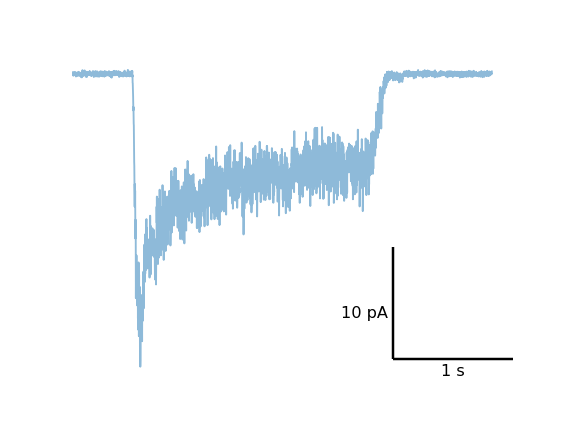

In [13]:
if "vc" in data:
    avg_vc_i = np.squeeze(np.mean(data["vc"]["a"], axis=0))
    
    soma_vci_avg_fig, soma_vci_avg_ax = plt.subplots(1)
    soma_vci_avg_ax.plot(rec_xaxis / 1000, avg_vc_i * 1000, alpha=0.5)
    
    soma_vci_avg_ax.set_xlabel("Time (s)")    
    soma_vci_avg_ax.set_ylabel("Somatic Current (pA)")    
    soma_vci_avg_ax.set_xlim(.5)
    add_scalebar(
        soma_vci_avg_ax,
        matchx=False,
        matchy=False,
        sizex=1,
        sizey=10,
        labelx="1 s",
        labely="10 pA",
        fontsize=13,
        sep=4,
        barwidth=2,
    )
    soma_vci_avg_fig.show()